In [133]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

figsize=(15, 10)
export_dir = './plots_SP/'
filetype = 'pdf'
env_name = 'prisoners dilemma 5 seed'
data_list = ['pd5s','pd5m','pd5l']
env_size = ['Small','Medium','Large']
seeds = 3
total_timestep = 6e6

sns.set()
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor":".93"})

In [134]:
def read_evaluation_data(data_list, size=500, smooth_alpha=0.05):
    full_data_total = pd.DataFrame()
    plot_data_total = pd.DataFrame()

    for _ in np.arange(len(data_list)):
        data_name = data_list[_]
        raw_data = np.load(f'/home/yuxin/meltingpot/MARL/SP_logs/{data_name}.npz')
        timesteps = raw_data['timesteps']
        policy_reward_min = raw_data['policy_reward_min']
        policy_reward_mean = raw_data['policy_reward_mean']
        policy_reward_max = raw_data['policy_reward_max']
        num_seeds = timesteps.shape[0]
        # num_agents = policy_reward_mean.shape[1]
        full_data = pd.DataFrame()
        plot_data = pd.DataFrame()
        count = 0
        for s in range(num_seeds):
            data = pd.DataFrame({'timesteps': timesteps[s,:], 'seeds': np.repeat(s, timesteps.shape[1]), 'env': np.repeat(env_size[_], timesteps.shape[1])})

            data['policy_reward_min'] = policy_reward_min[s,0,:]
            data['policy_reward_mean'] = policy_reward_mean[s,0,:]
            data['policy_reward_max'] = policy_reward_max[s,0,:]
            # remove NaN
            clean_data = data.dropna()

            # smooth data
            for (columnName, columnData) in clean_data.items():
                if columnName != 'timesteps' and columnName != 'seeds' and columnName != 'env':
                    clean_data[f'{columnName}_smooth'] = clean_data[columnName].ewm(alpha=smooth_alpha).mean()

            if count > 0:
                full_data = full_data.loc[full_data.timesteps.isin(clean_data.timesteps)]
                clean_data = clean_data.loc[clean_data.timesteps.isin(full_data.timesteps)]
            full_data = pd.concat([full_data, clean_data], axis=0)

            count += 1
            
        # reduce size for plotting
        count_row = full_data.shape[0] / num_seeds
        reduced_row = []
        for s in range(num_seeds):
            reduced_row.extend(np.linspace(count_row*s, count_row*(s+1)-1, size, dtype=int, endpoint=True).tolist())
        plot_data = full_data.iloc[reduced_row]

        full_data_total = pd.concat([full_data_total, full_data], axis=0)
        plot_data_total = pd.concat([plot_data_total, plot_data], axis=0)
    
    return full_data_total, plot_data_total

In [135]:
full_data, plot_data = read_evaluation_data(data_list, size=500)
plot_data

,timesteps,seeds,env,policy_reward_min,policy_reward_mean,policy_reward_max,policy_reward_min_smooth,policy_reward_mean_smooth,policy_reward_max_smooth
2,4800,0,Small,55.132540,62.605367,70.078194,55.132540,62.605367,70.078194
8,14400,0,Small,30.574603,48.858840,70.078194,36.716364,53.278013,70.078194
14,24000,0,Small,30.574603,50.306922,73.131907,33.373149,50.995661,70.689994
20,33600,0,Small,27.325397,47.624609,73.131907,30.800102,49.816501,71.728918
26,43200,0,Small,27.325397,46.874924,73.131907,29.526279,48.818023,72.243252
...,...,...,...,...,...,...,...,...,...
3099,4960000,4,Large,25.860985,57.077636,162.686694,26.590545,56.947912,160.139426
3105,4969600,4,Large,25.860985,57.603018,162.686694,26.397278,57.060139,160.814218
3111,4979200,4,Large,25.860985,57.757362,162.686694,26.255210,57.265772,161.310252
3117,4988800,4,Large,25.860985,57.378793,162.686694,26.150777,57.400707,161.674883


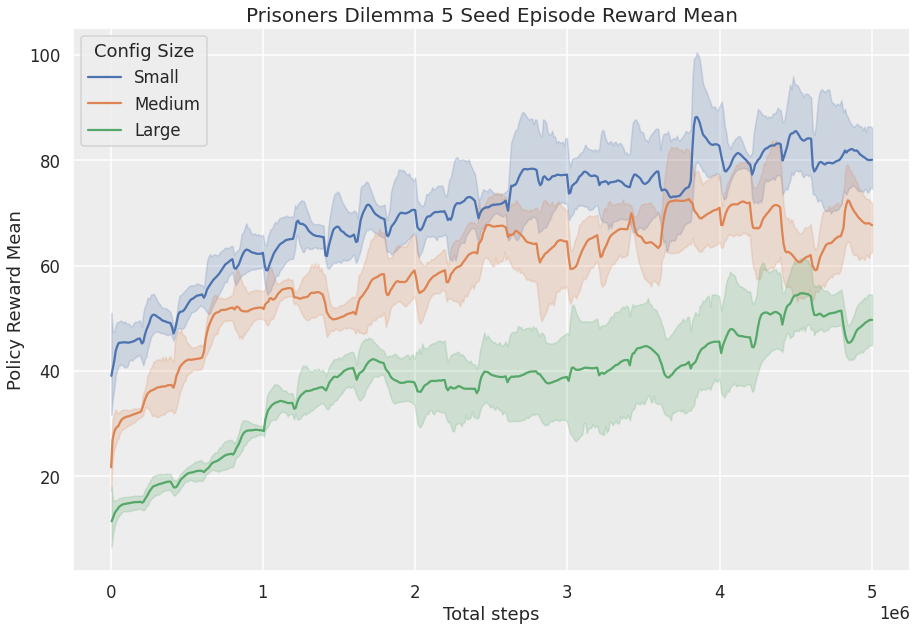

In [136]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=plot_data, x='timesteps', y='policy_reward_mean_smooth', hue='env')
ax.set(xlabel='Total steps', ylabel='Policy Reward Mean')
ax.set_title(env_name.title()+' Episode Reward Mean', fontsize=20, y=1.0)
# plt.xticks(np.arange(0, total_timestep, 2e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.legend(title='Config Size')
plt.savefig(os.path.join(export_dir, env_name+' reward mean.'+filetype), bbox_inches='tight')

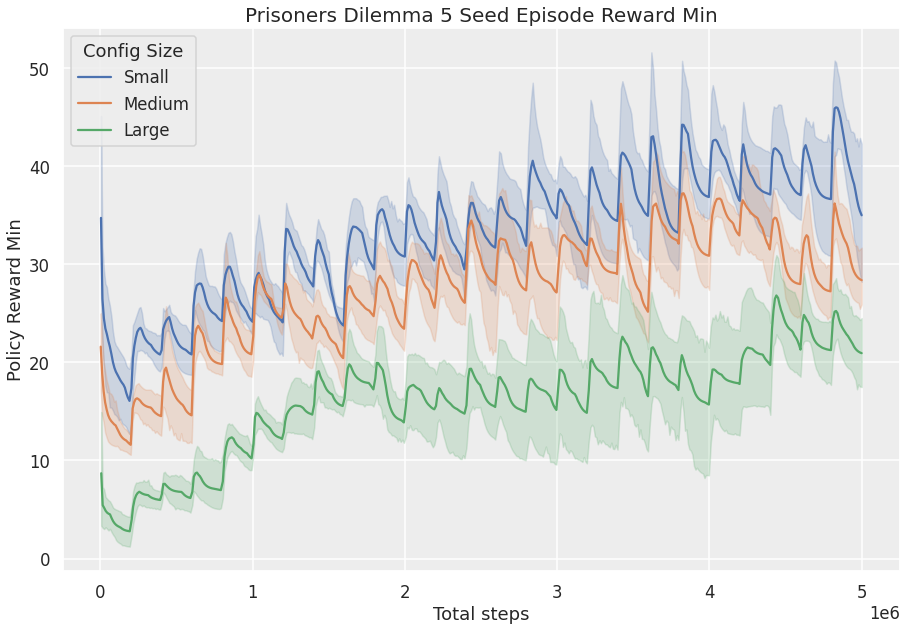

In [137]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=plot_data, x='timesteps', y='policy_reward_min_smooth', hue='env')
ax.set(xlabel='Total steps', ylabel='Policy Reward Min')
ax.set_title(env_name.title()+' Episode Reward Min', fontsize=20, y=1.0)
# plt.xticks(np.arange(0, total_timestep, 2e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.legend(title='Config Size')
plt.savefig(os.path.join(export_dir, env_name+' reward min.'+filetype), bbox_inches='tight')

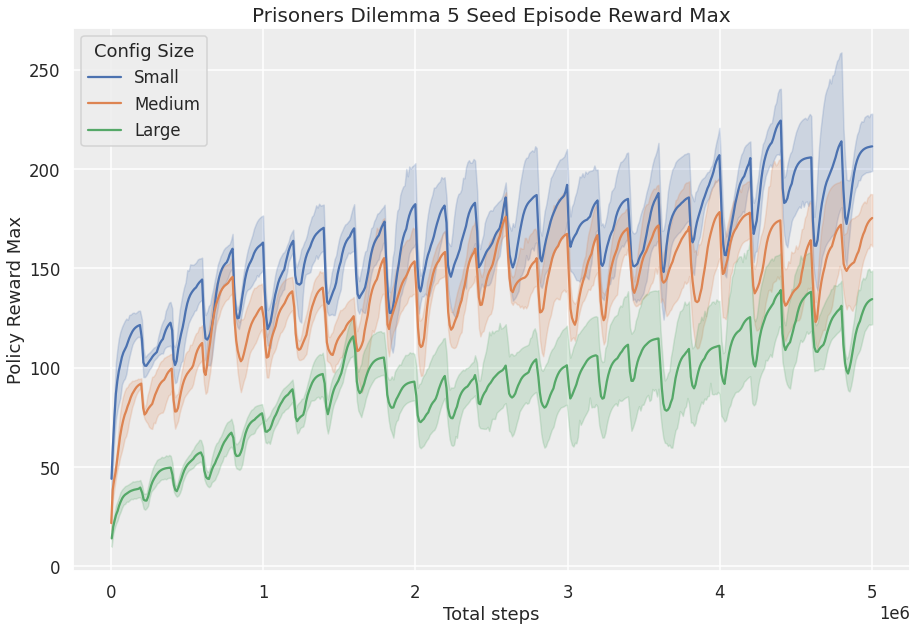

In [138]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=plot_data, x='timesteps', y='policy_reward_max_smooth', hue='env')
ax.set(xlabel='Total steps', ylabel='Policy Reward Max')
ax.set_title(env_name.title()+' Episode Reward Max', fontsize=20, y=1.0)
# plt.xticks(np.arange(0, total_timestep, 2e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.legend(title='Config Size')
plt.savefig(os.path.join(export_dir, env_name+' reward max.'+filetype), bbox_inches='tight')